# Extract profiles from SASSIE model at AXCTD coordinates

In [127]:
## Initalize Python libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import s3fs
import ujson
from glob import glob
from pathlib import Path
import s3fs
import boto3
import dask
from dask.distributed import Client, LocalCluster
import pyresample

**Summary of available data:** <br>

First model granule: 2014-01-15<br>
Last model granule: 2021-02-07<br>

AXCTD: summers 2016-2021

Overlap between datasets is 2016-2020 (5 years)

## Load data

### AXCTD data

In [49]:
# this doesn't work even if file permissions are chmod 777
axctd_dir = Path('~/efs-mount-point/mzahn/melville/AXCTD_data/combined/')
print(list(axctd_dir.glob("*nc")))

[]


In [472]:
# open combined AXCTD dataset
axctd_dir = '~/efs-mount-point/mzahn/melville/AXCTD_data/combined/'
axctd_ds = xr.open_mfdataset([axctd_dir + "OMG_Ocean_AXCTD_Greenland_2016.nc",\
                              axctd_dir + "OMG_Ocean_AXCTD_Greenland_2017.nc",\
                              axctd_dir + "OMG_Ocean_AXCTD_Greenland_2018.nc",\
                              axctd_dir + "OMG_Ocean_AXCTD_Greenland_2019.nc",\
                              axctd_dir + "OMG_Ocean_AXCTD_Greenland_2020.nc"],\
                             combine='nested',concat_dim='profile')

In [60]:
# make time a dimensional coordinate
axctd_ds = axctd_ds.swap_dims({"profile":"time"})

In [68]:
# confirm that the merging of the datasets worked properly
tmp = xr.open_dataset(axctd_dir + "OMG_Ocean_AXCTD_Greenland_2019.nc")
print(tmp.isel(profile=200).time.values)
print(tmp.isel(profile=200).lat.values)
print(tmp.isel(profile=200).lon.values)

2019-09-04T13:16:39.000000000
74.11423
-56.46232


In [75]:
print(axctd_ds.sel(time='2019-09-04T13:16:39').lat.values)
print(axctd_ds.sel(time='2019-09-04T13:16:39').lon.values)

74.11423
-56.46232


Looks good

### SASSIE model data

Open geometry file

In [8]:
# First open geometry file for HH field
HH_grid = xr.open_dataset("~/efs-mount-point/mzahn/sassie/HH/GRID/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc")

Open `SALT` and `THETA` fields

In [1]:
def get_aws_credentials(profile_name='sassie'):
    session = boto3.Session(profile_name=profile_name)
    credentials = session.get_credentials()

    return credentials

In [4]:
# load sassie profile credentials
aws_credentials = get_aws_credentials(profile_name='sassie')

In [5]:
# initialize s3 filesystem
s3_options = dict(anon=False, key=aws_credentials.access_key, secret=aws_credentials.secret_key)

In [6]:
# function to open zarr store with a provided s3 bucket path
def open_zarr_store(s3_path, s3_options):
    # initalize s3 file system
    s3 = s3fs.S3FileSystem(**s3_options)

    # define location of zarr store and open
    store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
    zarr_store = xr.open_zarr(store)
    
    return zarr_store

In [7]:
# open THETA zarr store
theta_zarr = open_zarr_store('s3://podaac-dev-sassie/ECCO_model/N1/V1R1/HH/ZARR/THETA_AVG_DAILY.ZARR/', s3_options)

# open SALT zarr store
salt_zarr = open_zarr_store('s3://podaac-dev-sassie/ECCO_model/N1/V1R1/HH/ZARR/SALT_AVG_DAILY.ZARR/', s3_options)

## Extract profiles from model

In [351]:
indexer = (np.logical_and(axctd_ds.lat>72,axctd_ds.lon<-50)).compute()

In [352]:
axctd_melville_ds = axctd_ds.where(indexer,drop=True)

In [356]:
axctd_melville_ds = axctd_melville_ds.where((axctd_ds.lat<76).compute(),drop=True)

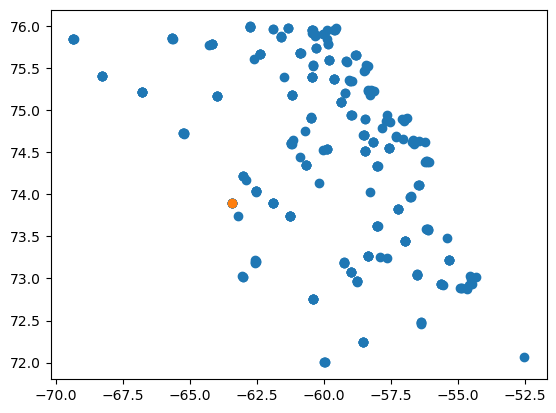

In [439]:
plt.scatter(axctd_melville_ds.lon,axctd_melville_ds.lat);
prof = axctd_melville_ds.isel(time=3)
plt.scatter(prof.lon,prof.lat);

In [440]:
time_tmp = axctd_melville_ds.isel(time=3).time.values
lat_tmp = axctd_melville_ds.isel(time=3).lat.values
lon_tmp = axctd_melville_ds.isel(time=3).lon.values

In [441]:
time_tmp1 = axctd_melville_ds.isel(time=6).time.values
lat_tmp1 = axctd_melville_ds.isel(time=6).lat.values
lon_tmp1 = axctd_melville_ds.isel(time=6).lon.values

In [442]:
# check time index
print(theta_zarr.sel(time=time_tmp, method='nearest').time.values)
print(time_tmp)

2016-09-24T12:00:00.000000000
2016-09-24T15:35:15.000000000


In [443]:
theta_day = theta_zarr.sel(time=time_tmp, method='nearest')

In [444]:
theta_day1 = theta_zarr.sel(time=time_tmp1, method='nearest')

In [445]:
# Find the indices of the closest latitude and longitude
distance = np.sqrt((theta_day.YC - lat_tmp)**2 + (theta_day.XC - lon_tmp)**2)
min_dist_index = distance.argmin(dim=['j', 'i']) # returns a dictionary

# Get the i, j indices of the closest point
i_idx = min_dist_index['i']
j_idx = min_dist_index['j']

# Use the indices to select the time series at the closest point
theta_profile = theta_day.sel(i=i_idx.values, j=j_idx.values)

In [446]:
# Find the indices of the closest latitude and longitude
distance = np.sqrt((theta_day1.YC - lat_tmp1)**2 + (theta_day1.XC - lon_tmp1)**2)
min_dist_index1 = distance.argmin(dim=['j', 'i']) # returns a dictionary

# Get the i, j indices of the closest point
i_idx1 = min_dist_index1['i']
j_idx1 = min_dist_index1['j']

# Use the indices to select the time series at the closest point
theta_profile1 = theta_day1.sel(i=i_idx1.values, j=j_idx1.values)

In [447]:
print(theta_profile.time.values)
print(theta_profile.YC.values)
print(theta_profile.XC.values)

2016-09-24T12:00:00.000000000
73.91295
-63.461937


In [448]:
print(time_tmp)
print(lat_tmp)
print(lon_tmp)

2016-09-24T15:35:15.000000000
73.89514
-63.43161


In [449]:
i_idx.values

array(1243)

In [450]:
j_idx.values

array(72)

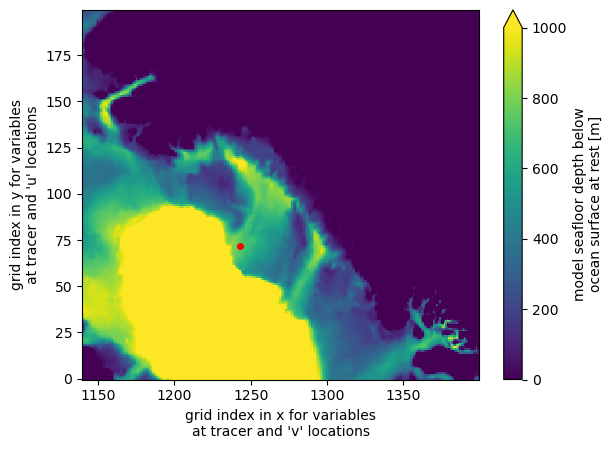

In [451]:
HH_grid.Depth.isel(i=slice(1140,1400),j=slice(0,200)).plot(vmin=0,vmax=1000);
plt.plot(i_idx.values,j_idx.values,'ro',markersize=4);

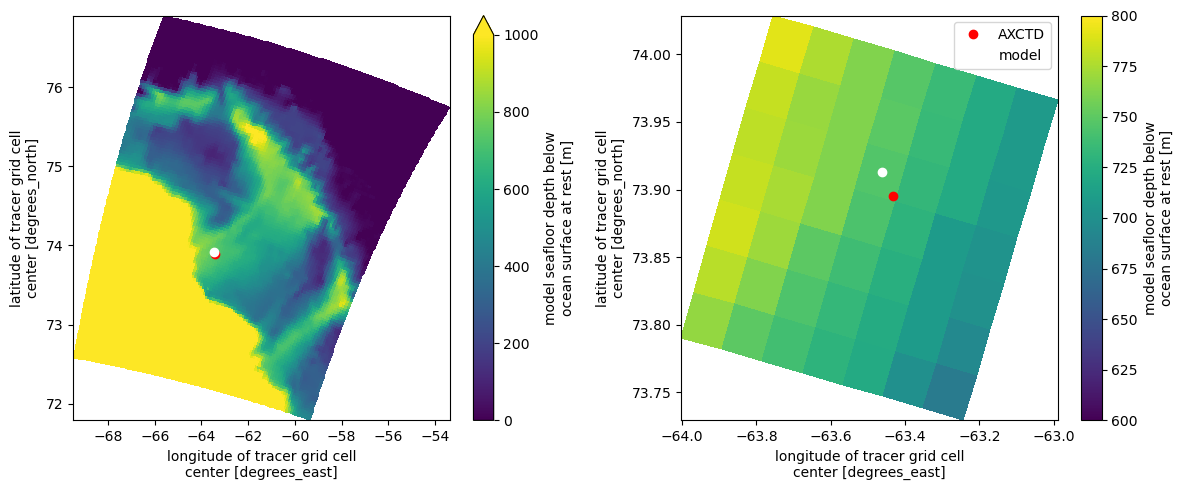

In [455]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[12,5])

HH_grid.Depth.isel(i=slice(1200,1300),j=slice(25,150)).plot(ax=ax1,y='YC',x='XC',vmin=0,vmax=1000);
ax1.plot(lon_tmp,lat_tmp,'ro');
ax1.plot(theta_profile.XC.values,theta_profile.YC.values,'wo');

HH_grid.Depth.isel(i=slice(1240,1247),j=slice(68,75)).plot(ax=ax2,y='YC',x='XC',vmin=600,vmax=800);
ax2.plot(lon_tmp,lat_tmp,'ro',label='AXCTD');
ax2.plot(theta_profile.XC.values,theta_profile.YC.values,'wo',label='model');
ax2.legend();

plt.tight_layout()

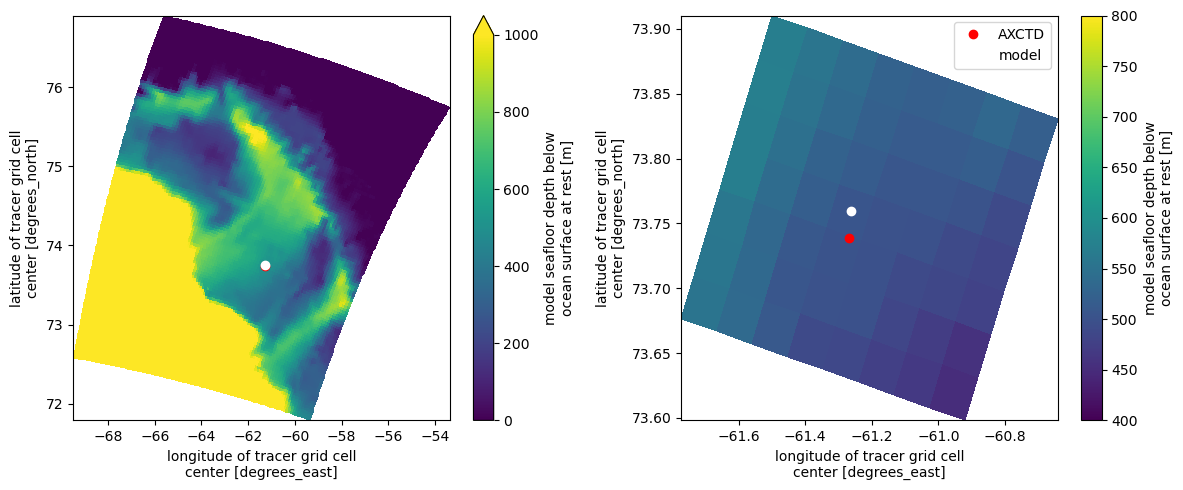

In [470]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[12,5])

HH_grid.Depth.isel(i=slice(1200,1300),j=slice(25,150)).plot(ax=ax1,y='YC',x='XC',vmin=0,vmax=1000);
ax1.plot(lon_tmp1,lat_tmp1,'ro');
ax1.plot(theta_profile1.XC.values,theta_profile1.YC.values,'wo');

HH_grid.Depth.isel(i=slice(1260,1268),j=slice(70,77)).plot(ax=ax2,y='YC',x='XC',vmin=400,vmax=800);
ax2.plot(lon_tmp1,lat_tmp1,'ro',label='AXCTD');
ax2.plot(theta_profile1.XC.values,theta_profile1.YC.values,'wo',label='model');
ax2.legend();

plt.tight_layout()

In [457]:
theta_profile_z = theta_profile.THETA.swap_dims({"k":"Z"})
theta_profile_z['Z'] = theta_profile_z.Z*(-1)

In [458]:
theta_profile_z1 = theta_profile1.THETA.swap_dims({"k":"Z"})
theta_profile_z1['Z'] = theta_profile_z1.Z*(-1)

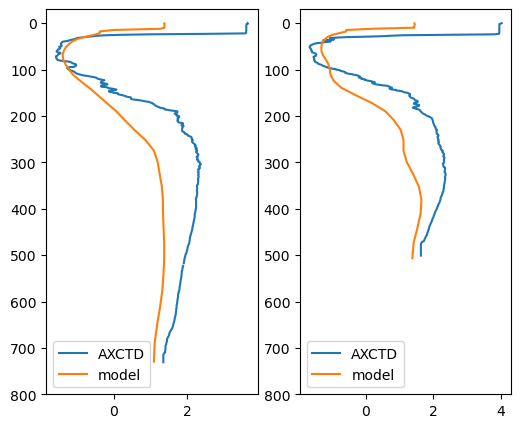

In [469]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[6,5])

ax1.plot(axctd_melville_ds.isel(time=3).temperature,axctd_melville_ds.isel(time=3).depth,label='AXCTD')
ax1.plot(theta_profile_z.values,theta_profile_z.Z.values,label='model');
ax1.legend()
ax1.set_ylim(800,-30);

ax2.plot(axctd_melville_ds.isel(time=6).temperature,axctd_melville_ds.isel(time=6).depth,label='AXCTD')
ax2.plot(theta_profile_z1.values,theta_profile_z1.Z.values,label='model');
ax2.legend()
ax2.set_ylim(800,-30);

Look at anomalies between years and between inshore/offshore